In [56]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LeakyReLU, Flatten, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import kagglehub

In [57]:
path = kagglehub.dataset_download("shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\domiw\.cache\kagglehub\datasets\shahzaibshazoo\detect-ai-generated-faces-high-quality-dataset\versions\1


In [58]:
dataset_path = path+"\\AI-face-detection-Dataset"
AI_img_path = dataset_path + "\\AI"
real_img_path = dataset_path + "\\real"

In [59]:
target_size = (224, 224)

In [60]:
def preprocess_images(folder, label, target_size):
    data = []
    labels = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            
            if img.mode != "RGB":
                img = img.convert("RGB")
            
            img = img.resize(target_size)
            
            img_array = np.array(img) / 255.0
            
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return data, labels

In [61]:
ai_data, ai_labels = preprocess_images(AI_img_path, label=0, target_size=target_size)  # Label 0 for AI
real_data, real_labels = preprocess_images(real_img_path, label=1, target_size=target_size)  # Label 1 for real

In [62]:
data = np.array(ai_data + real_data)
labels = np.array(ai_labels + real_labels)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [64]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [65]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
l1 = base_model.output
l2 = MaxPooling2D()(l1)
l3 = Flatten()(l2) 
l4 = Dense(128, activation='relu')(l3)
output = Dense(1, activation='sigmoid')(l4)

In [67]:
#l1 = base_model.output
#l2 = GlobalAveragePooling2D()(l1) 
#l3 = Dense(128)(l2)  # No activation here
#l4 = LeakyReLU(alpha=0.01)(l3)  # Applying LeakyReLU
#output = Dense(1, activation='sigmoid')(l4)

In [68]:
model = Model(inputs=base_model.input, outputs=output)

In [69]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.2,
    epochs=5,
    batch_size=32, 
    shuffle=False
)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6853 - loss: 1.3549 - val_accuracy: 0.9454 - val_loss: 0.1712
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9519 - loss: 0.1675 - val_accuracy: 0.9396 - val_loss: 0.1327
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9723 - loss: 0.1013 - val_accuracy: 0.9669 - val_loss: 0.0965
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9863 - loss: 0.0691 - val_accuracy: 0.9747 - val_loss: 0.0738
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9921 - loss: 0.0500 - val_accuracy: 0.9805 - val_loss: 0.0596


In [71]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 945ms/step - accuracy: 0.9879 - loss: 0.0521
Test Accuracy: 0.98


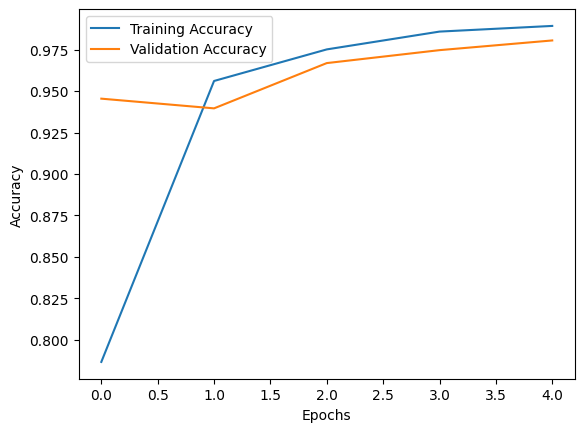

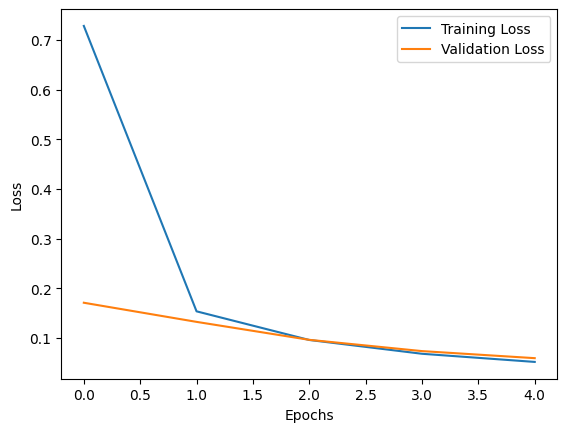

In [72]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


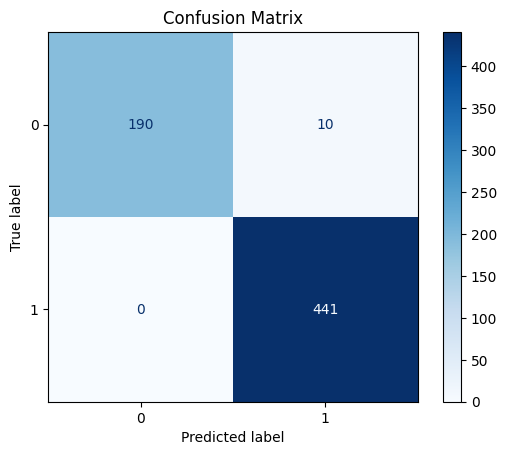

In [74]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [75]:
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in np.unique(y_test)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97       200
     Class 1       0.98      1.00      0.99       441

    accuracy                           0.98       641
   macro avg       0.99      0.97      0.98       641
weighted avg       0.98      0.98      0.98       641

